In [1]:
%matplotlib inline
import sys
sys.path.insert(1, '../../../../script/')
import math
import collections
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

import pydotplus
from sklearn import tree
from IPython.display import Image

import cleaning_class as cl
import cleaning_test as cl_test
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'imblearn'

In [97]:
df = pd.read_csv('../../data/training.csv') 
cl.cleaning(df)
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'Size',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentRetailAveragePrice', 'VNST',
       'VehBCost', 'WarrantyCost'],
      dtype='object')

### Balance the dataset

In [98]:
df["IsBadBuy"].value_counts()

0    48265
1     6672
Name: IsBadBuy, dtype: int64

In [99]:
df[df["IsBadBuy"]==0]["IsBadBuy"].value_counts()

0    48265
Name: IsBadBuy, dtype: int64

In [100]:
remove_n = 41411
drop_indices = np.random.choice(df[df["IsBadBuy"]==0].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
print(df_subset["IsBadBuy"].value_counts())

0    6854
1    6672
Name: IsBadBuy, dtype: int64


### Label Encoder and one hot encoder

In [101]:
df_subset = pd.get_dummies(df_subset)
df_subset = pd.get_dummies(df_subset, columns=['WheelTypeID'])
df_subset.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentRetailAveragePrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER', 'Size_COMPACT',
       'Size_CROSSOVER', 'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK',
       'Size_MEDIUM', 'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD', 'VNST_MI', 'VNST_MN', 'VNST_MO', 'VNST_MS', 'VNST_NC',
       'VNST_NE', 'VNST_NH', 'VNST_NJ', 'VNST_NM', 'VNST_NV', 'VNST_OH',
       'VNST_OK', 'VNST_OR', 'VNST_PA', 'VNST_SC', 'VNST_TN', 'VNST_TX',
       'VNST_UT', 'VNST_VA', 'VNST_WA', 'VNST_WV', 'WheelTypeID_1.0',
       'WheelTypeID_2.0', 'WheelType

### Train/Test partitioning

In [102]:
attributes = [col for col in df_subset.columns if col != 'IsBadBuy']
x = df_subset[attributes].values
y = df_subset['IsBadBuy']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

# Grid Search

In [103]:
def report(results, n_top=3):
    configurations = {}
    c_i = 0
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            configurations[c_i] = results['params'][candidate]
            c_i += 1 
    return configurations

In [104]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 10)),
              'min_samples_split': list(np.arange(2, 40)),
              'min_samples_leaf': list(np.arange(1, 40)),
             }

clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=10000, scoring='roc_auc', n_jobs = 4, verbose = 1)
random_search.fit(x, y)
cnfs = report(random_search.cv_results_, n_top=3)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 352 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 852 tasks      | elapsed:   25.0s
[Parallel(n_jobs=4)]: Done 1552 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done 2452 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 3552 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 4852 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 6352 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 8052 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 9952 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 12052 tasks      | elapsed:  5.6min
[Parallel(n_jobs=4)]: Done 14352 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 16852 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 19552 tasks      | elapsed:  9.1min
[Parallel(n_jobs=4)]: Done 22452 tasks      | elapsed: 1

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 35, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 32, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 22, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 33, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.670 (std: 0.005)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 9, 'max_depth': 5, 'criterion': 'gini'}

Model with rank: 1
Mean validation score:

### Perform Clustering

In [105]:
models = []
y_pred_vals = []
y_pred_trains = []
hyper_ps = random_search.cv_results_
for cnf in cnfs.values():
    criterion = cnf['criterion']
    max_depth = cnf['max_depth']
    min_samples_split = cnf['min_samples_split']
    min_samples_leaf = cnf['min_samples_leaf']
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    clf = clf.fit(x_train, y_train)
    models.append(clf)
    y_pred = clf.predict(x_val)
    y_pred_tr = clf.predict(x_train)
    y_pred_vals.append(y_pred)
    y_pred_trains.append(y_pred_tr)   

### Analyze the classification results

In [106]:
for i in range(0,5):
    print("model {}".format(i))
    print('Train Accuracy %s' % accuracy_score(y_train, y_pred_trains[i]))
    print('Train F1-score %s' % f1_score(y_train, y_pred_trains[i], average=None))
    print()

    print('Test Accuracy %s' % accuracy_score(y_val, y_pred_vals[i]))
    print('Test F1-score %s' % f1_score(y_val, y_pred_vals[i], average=None))
    print(classification_report(y_val, y_pred_vals[i]))
    confusion_matrix(y_val, y_pred_vals[i])

model 0
Train Accuracy 0.6158639628221377
Train F1-score [0.62739473 0.60359673]

Test Accuracy 0.6153277476589453
Test F1-score [0.63035757 0.59902389]
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      2056
           1       0.62      0.58      0.60      2002

    accuracy                           0.62      4058
   macro avg       0.62      0.61      0.61      4058
weighted avg       0.62      0.62      0.61      4058

model 1
Train Accuracy 0.6158639628221377
Train F1-score [0.62739473 0.60359673]

Test Accuracy 0.6153277476589453
Test F1-score [0.63035757 0.59902389]
              precision    recall  f1-score   support

           0       0.61      0.65      0.63      2056
           1       0.62      0.58      0.60      2002

    accuracy                           0.62      4058
   macro avg       0.62      0.61      0.61      4058
weighted avg       0.62      0.62      0.61      4058

model 2
Train Accuracy 0.615863962822137

### Analyze the classification performance

In [107]:
roc_auc_models = []
for i in range(0,5):
    fpr, tpr, _ = roc_curve(y_val, y_pred_vals[i])
    roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(y_val, y_pred_vals[i], average=None)
    print("model {} - roc_auc: {}".format(i, roc_auc))
    roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.6148955616368067
model 1 - roc_auc: 0.6148955616368067
model 2 - roc_auc: 0.6148955616368067
model 3 - roc_auc: 0.6148955616368067
model 4 - roc_auc: 0.6148955616368067


### Choose the best model

Visualize the decision tree

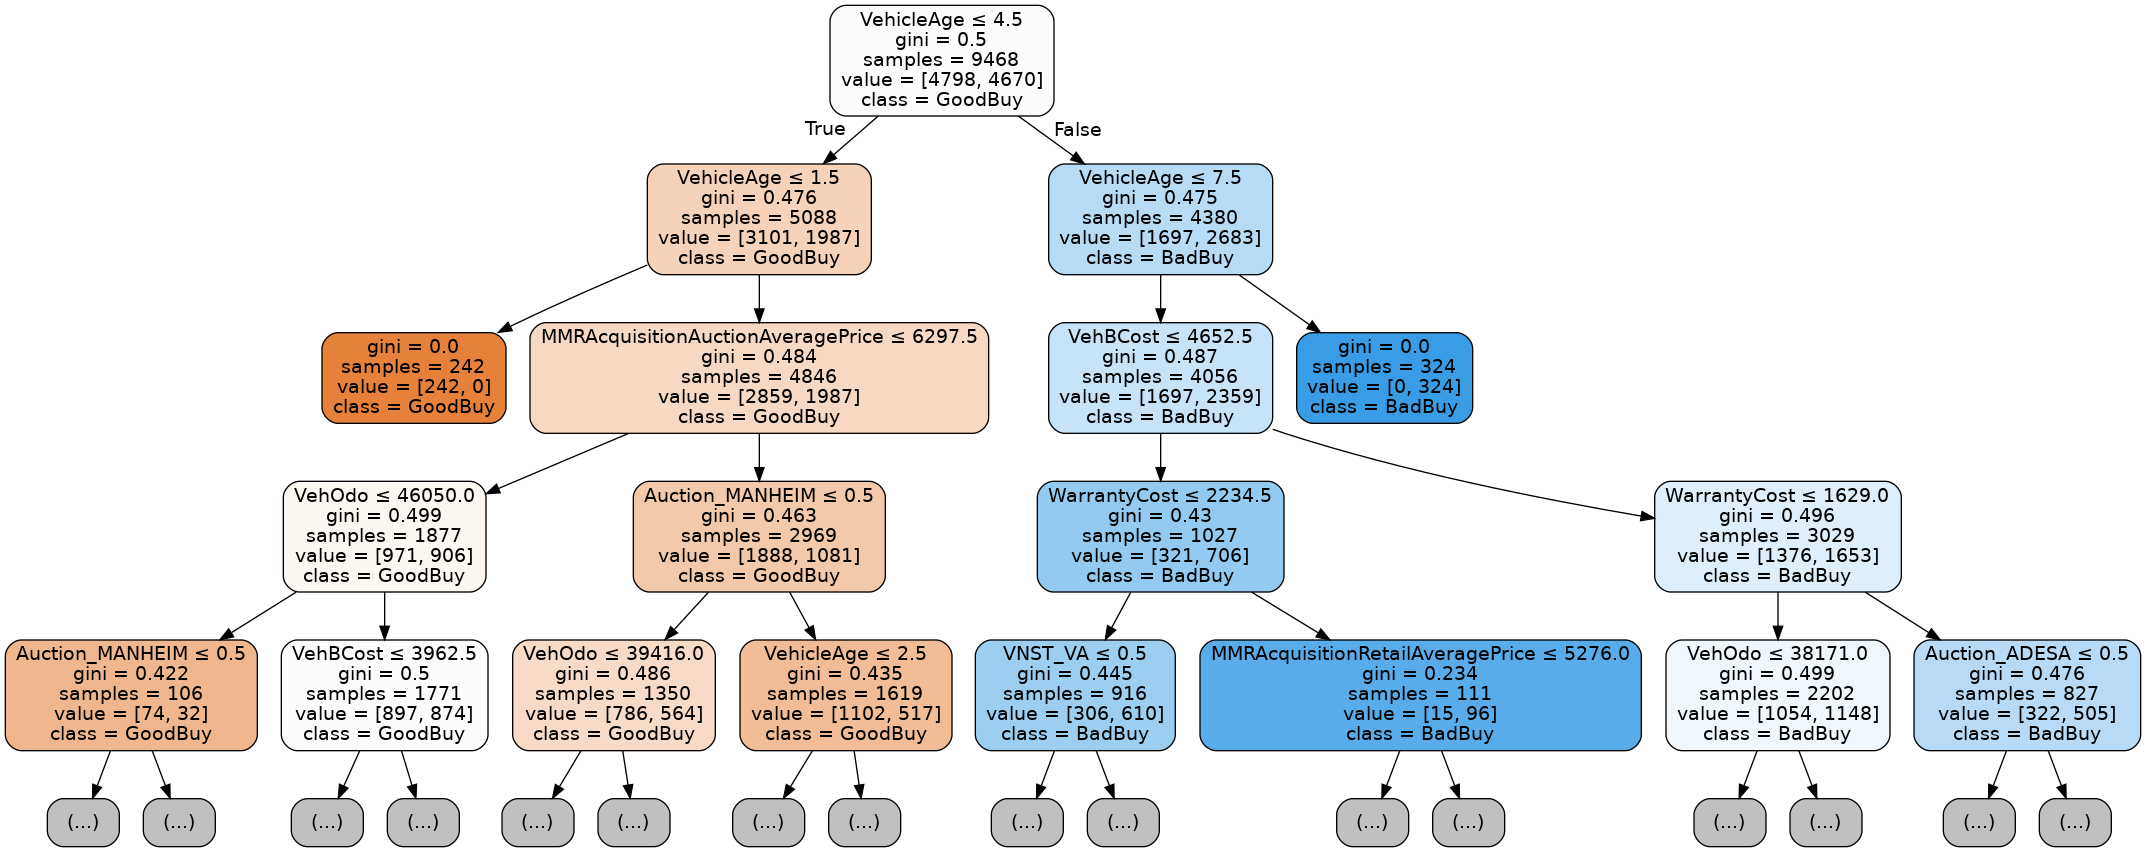

In [108]:
dot_data = tree.export_graphviz(models[0], out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Evaluate the performance

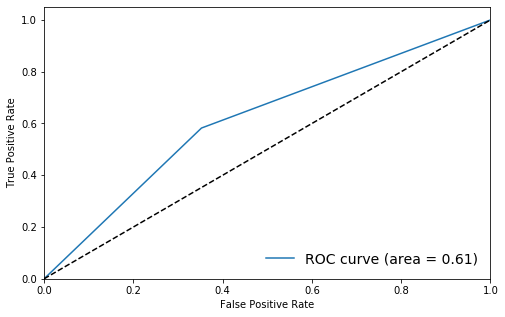

In [109]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc_models[0]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

Features Importance

In [ ]:
for col, imp in zip(attributes, models[2].feature_importances_):
    print(col, imp)

# Model evaluation on test set

In [89]:
df_test = pd.read_csv('../../data/test.csv') 
cl_test.cleaning(df_test)
df_test.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Transmission', 'WheelTypeID',
       'VehOdo', 'Nationality', 'Size', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VNST', 'VehBCost', 'WarrantyCost'],
      dtype='object')

In [90]:
df_test = pd.get_dummies(df_test)
df_test = pd.get_dummies(df_test, columns=['WheelTypeID'])
df_test.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER',
       'Transmission_AUTO', 'Transmission_MANUAL', 'Nationality_AMERICAN',
       'Nationality_OTHER', 'Nationality_OTHER ASIAN',
       'Nationality_TOP LINE ASIAN', 'Size_COMPACT', 'Size_CROSSOVER',
       'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK', 'Size_MEDIUM',
       'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD

In [91]:
attributes = [col for col in df_test.columns if col != 'IsBadBuy']
x_test = df_test[attributes].values
y_test = df_test['IsBadBuy']

In [92]:
y_pred_test = models[0].predict(x_test)

Test Accuracy 0.5249383392710332
Test F1-score [0.64930204 0.26390658]
              precision    recall  f1-score   support

           0       0.92      0.50      0.65     12828
           1       0.16      0.70      0.26      1768

    accuracy                           0.52     14596
   macro avg       0.54      0.60      0.46     14596
weighted avg       0.83      0.52      0.60     14596

Confusion matrix, without normalization
[[6419 6409]
 [ 525 1243]]
Normalized confusion matrix
[[0.50038977 0.49961023]
 [0.2969457  0.7030543 ]]


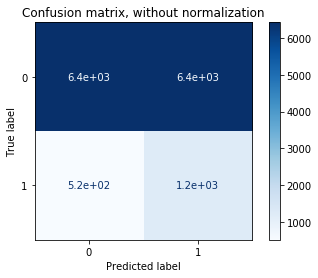

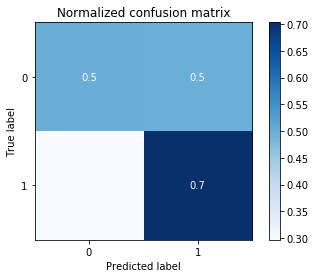

In [93]:
print('Test Accuracy %s' % accuracy_score(y_test, y_pred_test))
print('Test F1-score %s' % f1_score(y_test, y_pred_test, average=None))
print(classification_report(y_test, y_pred_test))

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(models[0], x_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)

plt.show()


In [94]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, y_pred_test, average=None)
print("model {} - roc_auc: {}".format(0, roc_auc))
roc_auc_models.append(roc_auc)

model 0 - roc_auc: 0.6017220355077341


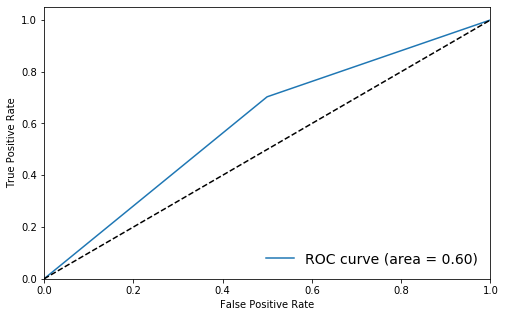

In [95]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()